In [9]:
# Install if needed
# !pip install xgboost

import pandas as pd
import numpy as np
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Load dataset
file_path = "epileptic_seizure_recognition.csv"
df = pd.read_csv(file_path)
df.rename(columns={df.columns[-1]: "label"}, inplace=True)
df_cleaned = df.iloc[:, 1:]
df_filtered = df_cleaned[df_cleaned["label"].isin([1, 2, 3])]

# Prepare features and labels
X = df_filtered.iloc[:, :-1].values
y = df_filtered["label"].values

# Standardize EEG chunks
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply FFT → convert each EEG chunk to frequency space
X_freq = np.abs(fft(X_scaled))[:, :89]  # Keep only positive frequencies

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_freq, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Regularized params
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'learning_rate': 0.03,
    'max_depth': 4,
    'n_estimators': 150,  # Used as num_boost_round
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1.0,
    'reg_lambda': 2.0,
    'verbosity': 1
}

# Train model with early stopping on test set
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=150,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

# Evaluate performance
y_train_pred = model.predict(dtrain)
y_test_pred = model.predict(dtest)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Classification report
print("\n📊 Classification Report (Super Regularized XGBoost):")
print(classification_report(y_test, y_test_pred, target_names=["Seizure Activity", "Tumor Area", "Healthy Region"]))


[0]	train-mlogloss:1.07861	eval-mlogloss:1.07903
[1]	train-mlogloss:1.05963	eval-mlogloss:1.06047
[2]	train-mlogloss:1.04162	eval-mlogloss:1.04268
[3]	train-mlogloss:1.02406	eval-mlogloss:1.02540
[4]	train-mlogloss:1.00733	eval-mlogloss:1.00894
[5]	train-mlogloss:0.99125	eval-mlogloss:0.99310
[6]	train-mlogloss:0.97591	eval-mlogloss:0.97830
[7]	train-mlogloss:0.96127	eval-mlogloss:0.96398
[8]	train-mlogloss:0.94692	eval-mlogloss:0.95020
[9]	train-mlogloss:0.93323	eval-mlogloss:0.93673
[10]	train-mlogloss:0.92020	eval-mlogloss:0.92397
[11]	train-mlogloss:0.90769	eval-mlogloss:0.91190
[12]	train-mlogloss:0.89555	eval-mlogloss:0.90017
[13]	train-mlogloss:0.88388	eval-mlogloss:0.88881
[14]	train-mlogloss:0.87246	eval-mlogloss:0.87762
[15]	train-mlogloss:0.86140	eval-mlogloss:0.86702
[16]	train-mlogloss:0.85088	eval-mlogloss:0.85697
[17]	train-mlogloss:0.84074	eval-mlogloss:0.84712


/Users/gc/.pyenv/versions/3.10.6/envs/NeuroPredict/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [11:24:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[18]	train-mlogloss:0.83081	eval-mlogloss:0.83743
[19]	train-mlogloss:0.82136	eval-mlogloss:0.82814
[20]	train-mlogloss:0.81222	eval-mlogloss:0.81936
[21]	train-mlogloss:0.80322	eval-mlogloss:0.81072
[22]	train-mlogloss:0.79457	eval-mlogloss:0.80257
[23]	train-mlogloss:0.78632	eval-mlogloss:0.79477
[24]	train-mlogloss:0.77812	eval-mlogloss:0.78701
[25]	train-mlogloss:0.77024	eval-mlogloss:0.77941
[26]	train-mlogloss:0.76268	eval-mlogloss:0.77220
[27]	train-mlogloss:0.75521	eval-mlogloss:0.76511
[28]	train-mlogloss:0.74808	eval-mlogloss:0.75853
[29]	train-mlogloss:0.74121	eval-mlogloss:0.75194
[30]	train-mlogloss:0.73432	eval-mlogloss:0.74551
[31]	train-mlogloss:0.72769	eval-mlogloss:0.73921
[32]	train-mlogloss:0.72125	eval-mlogloss:0.73318
[33]	train-mlogloss:0.71493	eval-mlogloss:0.72724
[34]	train-mlogloss:0.70893	eval-mlogloss:0.72156
[35]	train-mlogloss:0.70302	eval-mlogloss:0.71608
[36]	train-mlogloss:0.69734	eval-mlogloss:0.71068
[37]	train-mlogloss:0.69184	eval-mlogloss:0.70540


In [13]:
# Empty dictionary to capture train/test log loss
evals_result = {}

# Train the model and store evaluation log loss
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=150,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=20,
    evals_result=evals_result,  # ✅ Add this line
    verbose_eval=True
)



[0]	train-mlogloss:1.07861	eval-mlogloss:1.07903
[1]	train-mlogloss:1.05963	eval-mlogloss:1.06047
[2]	train-mlogloss:1.04162	eval-mlogloss:1.04268
[3]	train-mlogloss:1.02406	eval-mlogloss:1.02540
[4]	train-mlogloss:1.00733	eval-mlogloss:1.00894
[5]	train-mlogloss:0.99125	eval-mlogloss:0.99310
[6]	train-mlogloss:0.97591	eval-mlogloss:0.97830
[7]	train-mlogloss:0.96127	eval-mlogloss:0.96398
[8]	train-mlogloss:0.94692	eval-mlogloss:0.95020
[9]	train-mlogloss:0.93323	eval-mlogloss:0.93673
[10]	train-mlogloss:0.92020	eval-mlogloss:0.92397
[11]	train-mlogloss:0.90769	eval-mlogloss:0.91190
[12]	train-mlogloss:0.89555	eval-mlogloss:0.90017
[13]	train-mlogloss:0.88388	eval-mlogloss:0.88881
[14]	train-mlogloss:0.87246	eval-mlogloss:0.87762
[15]	train-mlogloss:0.86140	eval-mlogloss:0.86702
[16]	train-mlogloss:0.85088	eval-mlogloss:0.85697
[17]	train-mlogloss:0.84074	eval-mlogloss:0.84712
[18]	train-mlogloss:0.83081	eval-mlogloss:0.83743
[19]	train-mlogloss:0.82136	eval-mlogloss:0.82814
[20]	train

/Users/gc/.pyenv/versions/3.10.6/envs/NeuroPredict/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [11:26:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[23]	train-mlogloss:0.78632	eval-mlogloss:0.79477
[24]	train-mlogloss:0.77812	eval-mlogloss:0.78701
[25]	train-mlogloss:0.77024	eval-mlogloss:0.77941
[26]	train-mlogloss:0.76268	eval-mlogloss:0.77220
[27]	train-mlogloss:0.75521	eval-mlogloss:0.76511
[28]	train-mlogloss:0.74808	eval-mlogloss:0.75853
[29]	train-mlogloss:0.74121	eval-mlogloss:0.75194
[30]	train-mlogloss:0.73432	eval-mlogloss:0.74551
[31]	train-mlogloss:0.72769	eval-mlogloss:0.73921
[32]	train-mlogloss:0.72125	eval-mlogloss:0.73318
[33]	train-mlogloss:0.71493	eval-mlogloss:0.72724
[34]	train-mlogloss:0.70893	eval-mlogloss:0.72156
[35]	train-mlogloss:0.70302	eval-mlogloss:0.71608
[36]	train-mlogloss:0.69734	eval-mlogloss:0.71068
[37]	train-mlogloss:0.69184	eval-mlogloss:0.70540
[38]	train-mlogloss:0.68641	eval-mlogloss:0.70024
[39]	train-mlogloss:0.68108	eval-mlogloss:0.69531
[40]	train-mlogloss:0.67594	eval-mlogloss:0.69045
[41]	train-mlogloss:0.67088	eval-mlogloss:0.68570
[42]	train-mlogloss:0.66613	eval-mlogloss:0.68126


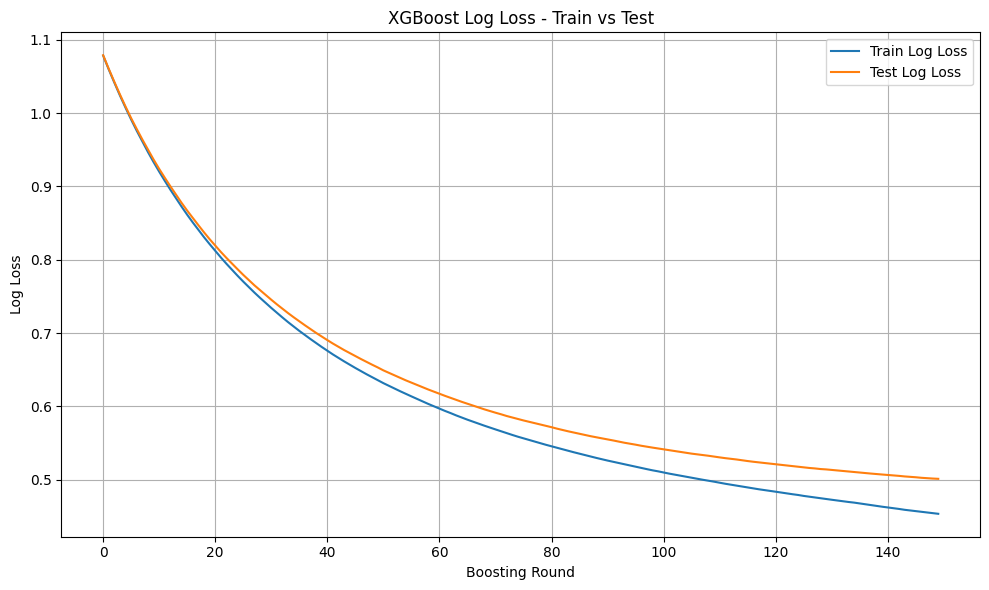

In [14]:
import matplotlib.pyplot as plt

# Plot the log loss
train_loss = evals_result['train']['mlogloss']
test_loss = evals_result['eval']['mlogloss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Log Loss')
plt.plot(test_loss, label='Test Log Loss')
plt.title('XGBoost Log Loss - Train vs Test')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


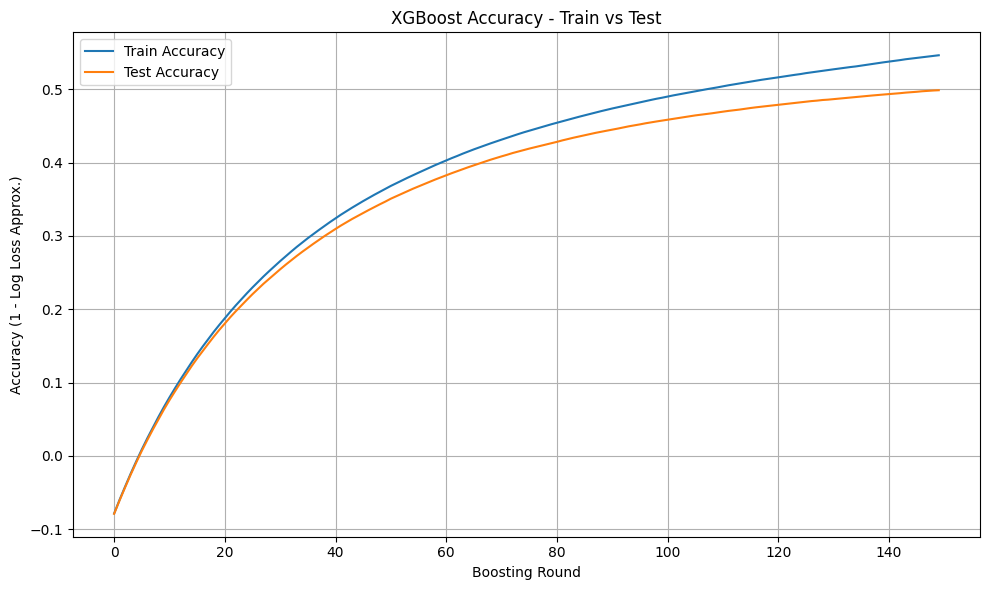

In [15]:
# Calculate accuracy at each round
train_acc = [1 - loss for loss in evals_result['train']['mlogloss']]
test_acc = [1 - loss for loss in evals_result['eval']['mlogloss']]

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('XGBoost Accuracy - Train vs Test')
plt.xlabel('Boosting Round')
plt.ylabel('Accuracy (1 - Log Loss Approx.)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


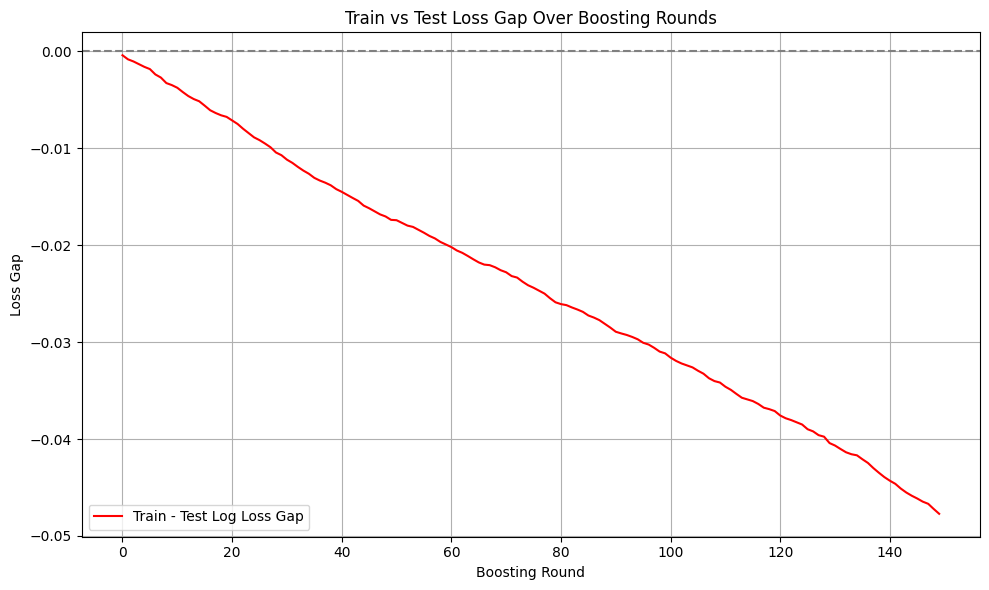

In [16]:
gap = np.array(train_loss) - np.array(test_loss)

plt.figure(figsize=(10, 6))
plt.plot(gap, label='Train - Test Log Loss Gap', color='red')
plt.title('Train vs Test Loss Gap Over Boosting Rounds')
plt.xlabel('Boosting Round')
plt.ylabel('Loss Gap')
plt.axhline(0, linestyle='--', color='gray')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
